@author: spe

This example covers calculating the forces in a standard, six-beam CaF MOT.
The goal is to reproduce the figures in PRA 92 053401 (2015).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as cts
import pylcp
import pylcp.tools
#plt.style.use('paper')

Define the Hamiltonian first.

In [2]:
Gamma = 8.3 # MHz

# CaF numbers: Journal of Molecular Spectroscopy, 86 (2), 365 (1981)
H0_X, Bq_X, U_X, Xbasis = pylcp.hamiltonians.XFmolecules.Xstate(
    N=1, Lambda=0, B=0, b=109.1893/Gamma, c=40.1190/Gamma,
    cc=2.876e-2/Gamma, gamma=39.65891/Gamma,
    muB=cts.value('Bohr magneton in Hz/T')/1e6*1e-4/Gamma, return_basis=True
    )
E_X = np.unique(np.diag(H0_X))
H0_A, Bq_A, Abasis = pylcp.hamiltonians.XFmolecules.Astate(
    P=+1, Ahfs=2.4/Gamma, q=0, p=0, gJ=2*-0.021,
    muB=cts.value('Bohr magneton in Hz/T')/1e6*1e-4/Gamma, return_basis=True
    )
E_A = np.unique(np.diag(H0_A))

dijq = pylcp.hamiltonians.XFmolecules.dipoleXandAstates(
    Xbasis, Abasis, I1=1/2, S=1/2, UX=U_X
    )

hamiltonian = pylcp.hamiltonian(H0_X, H0_A, Bq_X, Bq_A, dijq)

There are some small things to consider.  First, they use total power in each
beam rather than saturation intensity.  In the paper, they assume unclipped
Gaussian beams of w=12 mm 1/e^2 radius and use powers of 5, 15, 40 and 100 mW.
The relationship between intensity and power is given by I = 2 P/pi w^2.
Moreover, I_sat = 2 pi**2 hbar c Gamma/lambda**2.  They also assume 20 G/cm.
Given that we define muB above in terms of linewidth/G, it should be just as
simple as plugging in 2 G/mm in the magField.

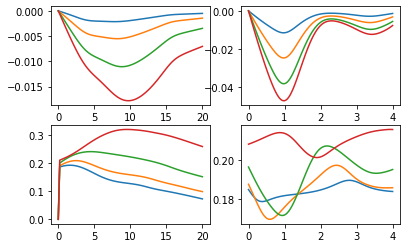

In [3]:
omega = 2*np.pi*(cts.c/606e-9)
Isat = cts.hbar*omega**3*(2*np.pi*Gamma*1e6)/(12*np.pi*cts.c**2)
#print("I_sat = ", Isat*1e-4*1e3)
P = np.array([0.005, 0.015, 0.040, 0.1])
betas = 2.*P/(np.pi*0.012**2)/Isat

# The detunings used in the PRAs:
dets = np.array([-0.25, -0.5, -1, -2])

# A litle helper function to make the MOT:
def six_beam_CaF_MOT(beta, det):
    laserBeams = pylcp.laserBeams()
    for ii, Eg_i in enumerate(E_X):
        if ii<3:
            laserBeams += pylcp.tools.standard_six_beam_MOT(
                beta=beta, delta=(E_A[-1] - Eg_i)+det, pol=+1
                )
        else:
            laserBeams += pylcp.tools.standard_six_beam_MOT(
                beta=beta, delta=(E_A[-1] - Eg_i)+det, pol=-1
                )

    return laserBeams

# Make the magnetic field:
magField = lambda R: pylcp.tools.quadrupoleField3D(R, 2)

# Make the axis:
z = np.linspace(1e-10, 20., 101)
v = np.linspace(0., 4., 101)

# Start the figure:
fig, ax = plt.subplots(2, 2, figsize=(6.25, 4), num="Forces in CaF MOT")
for ii, beta_i in enumerate(betas):
    laserBeams = six_beam_CaF_MOT(beta_i, dets[2])
    trap = pylcp.trap_rateeq(laserBeams, magField, hamiltonian, include_mag_forces=False)
    trap.generate_force_profile(
        [np.zeros(z.shape), np.zeros(z.shape), z],
        [np.zeros(z.shape), np.zeros(z.shape), np.zeros(z.shape)],
        name='Fz')
    trap.generate_force_profile(
        [np.zeros(v.shape), np.zeros(v.shape), 1e-3*np.ones(v.shape)],
        [np.zeros(v.shape), np.zeros(v.shape), v],
        name='Fv')
    ax[0, 0].plot(z, trap.profile['Fz'].F[2], color='C{0:d}'.format(ii))
    ax[0, 1].plot(v, trap.profile['Fv'].F[2], color='C{0:d}'.format(ii))

for ii, det_i in enumerate(dets):
    laserBeams = six_beam_CaF_MOT(betas[2], det_i)
    trap = pylcp.trap_rateeq(laserBeams, magField, hamiltonian)
    trap.generate_force_profile(
        [np.zeros(z.shape), np.zeros(z.shape), z],
        [np.zeros(z.shape), np.zeros(z.shape), np.zeros(z.shape)],
        name='Fz')
    trap.generate_force_profile(
        [np.zeros(v.shape), np.zeros(v.shape), 1e-3*np.ones(v.shape)],
        [np.zeros(v.shape), np.zeros(v.shape), v],
        name='Fv')
    ax[1, 0].plot(z, trap.profile['Fz'].F[2], color='C{0:d}'.format(ii))
    ax[1, 1].plot(v, trap.profile['Fv'].F[2], color='C{0:d}'.format(ii))

Next, make the two color MOT of CaF (Fig. 4)

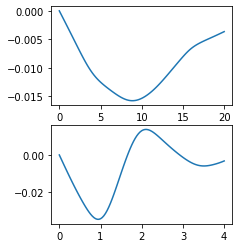

In [4]:
laserBeams = six_beam_CaF_MOT(betas[2], dets[2])
laserBeams += pylcp.tools.standard_six_beam_MOT(
    beta=betas[2], delta=(E_A[-1] - E_X[0]) + 2, pol=-1
    )

fig, ax = plt.subplots(2, 1, figsize=(3.25, 4),
                       num="Forces in two-color CaF MOT")

trap = pylcp.trap_rateeq(laserBeams, magField, hamiltonian, include_mag_forces=False)
trap.generate_force_profile(
    [np.zeros(z.shape), np.zeros(z.shape), z],
    [np.zeros(z.shape), np.zeros(z.shape), np.zeros(z.shape)],
    name='Fz')
trap.generate_force_profile(
    [np.zeros(v.shape), np.zeros(v.shape), 1e-3*np.ones(v.shape)],
    [np.zeros(v.shape), np.zeros(v.shape), v],
    name='Fv')
ax[0].plot(z, trap.profile['Fz'].F[2])
ax[1].plot(v, trap.profile['Fv'].F[2])